In [185]:
from qat.lang.AQASM import Program, H, CNOT, RX, RY, RZ, X, Z
import numpy as np
from qat.qpus import PyLinalg
from numpy import linalg
from qat.qpus import get_default_qpu
from qat.core import Observable, Term
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Variational Quantum Eigensolver (VQE)

O VQE é um algoritmo proposto em \ref para realizar a preparação do estado fundamental de energia de moléculas, onde o hamiltoniano, $H$, do sistema, que descreve sua energia, é escrito em termos de operadores de Pauli ($X$, $Y$, $Z$ e $I$) e um processo de otimização é realizado a fim de se encontrar o menor autovalor deste operador.

    - Material de apoio: Aula VQE

Neste notebook tutorial, implementaremos o VQE utilizando as ferramentas `myQLM` e do `SciPy`. Veremos duas possíveis aplicações desse algoritmo. São elas:

    - Simulação quântica 
    - Otimização combinatória

### Simulação da molécula $H_2$ no equilíbrio

Agora, vamos encontrar o nível fundamental de energia da molécula de hidrogênio com o VQE. Este é um problema extremamente custoso para moléculas com mais átomos. Contudo, é um problema de grande relevância para o descobrimento de novos materiais e novos medicamentos. 

Neste notebook, concentraremos nossos esforços em encontrar o nível fundamental de energia de um dado Hamiltoniano da molécula de $H_2$ e não nos preocuparemos com a modelagem hamiltoniana, cujo pre-requisito é um conhecimento um pouco mais avançado de conceitos de química quântica. 

O hamiltoniano da molécula de hidrgênio no equilíbrio, onde a distância entre os dois átomos de hidrogênio é aproximadamente $0.76 \text{ Angstrom}$, é dado por 

$$H = (-1.0523732)II + 
                 (0.39793742)IZ + 
                 (-0.3979374)ZI + 
                 (-0.0112801)ZZ + 
                 (0.18093119)XX$$

Note que o produto entre os operadores de cada termo é um produto tensorial (Ex: $IZ \equiv I \otimes Z$).

##### Exercício:
Escreva $H$ na forma matricial e use um solver para encontrar seus autovalores. No final, compare com o resultado do VQE. Dica: use funções do Numpy, como np.matrix() para criar as matrizes de Pauli, np.kron() para realizar produtos tensoriais e np.linalg.eig() para encontrar autovalores.

### Ansatz

O ansatz é um circuito quântico parametrizado. Sua forma variacional pode ser dada por padrões heurísticos geralmente implementada através de operadores de rotação e portas CNOT para realizar emaranhamento entre os qubits. Uma forma variacional eficiente é aquela capaz de generalizar bem um estado quântico, aumentando o espaço de busca. Podemos escrever a atuação do circuito variacional, $U(\vec{\theta})$, sobre um sistema com $n$ qubits de estado inicial, $|0\rangle^{\otimes n}$, como

$$U(\vec{\theta})|0\rangle^{\otimes n} = |\psi(\vec{\theta})\rangle$$

In [186]:
def ansatz(var_params):

    qprog = Program()
    qbits = qprog.qalloc(2)

    # cria um ansatz com uma layer e 4 parametros
    qprog.apply(RX(var_params[0]),qbits[0])
    qprog.apply(RY(var_params[1]),qbits[1])
    qprog.apply(CNOT, qbits[0],qbits[1])
    qprog.apply(RX(var_params[2]),qbits[0])
    qprog.apply(RY(var_params[3]),qbits[1])
   
    
    circ = qprog.to_circ()

    return circ

In [187]:
qc = ansatz([i for i in range(6)])
%qatdisplay qc --svg

### Valor esperado de $H$

O operador hamiltoniano da molécula de hidrogênio apresentado foi escrito como uma combinação linear de 5 produtos de operadores de Pauli e seus respectivos coeficientes. Um dos operadores é uma matriz identidade, cujo valor esperado é sempre 1. Portanto, serão necessárias medidas em 4 diferentes bases. O valor esperado de $H$ pode ser escrito como: (Obs: utilizaremos a notação simplificada $\langle H \rangle \equiv \langle \vec{\theta} | H | \vec{\theta} \rangle $.)

$$\langle H \rangle = (-1.0523732) \langle II \rangle  + 
                 (0.39793742) \langle IZ \rangle + 
                 (-0.3979374) \langle ZI \rangle + 
                 (-0.0112801) \langle ZZ \rangle + 
                 (0.18093119) \langle XX \rangle $$

Diante do que foi exposto na aula sobre o VQE, podemos observar que o único termo da soma onde serão necessárias operaações adicionais ao circuito quântico para a medida do valor esperado é o termo $\langle XX \rangle$. Como foi visto, para calcular esse valor devemos realizar a transformação $X\otimes X = (HZH) \otimes (HZH)$ para calcular seu valor esperado através de medidas na base computacional. Felizmente, a classe Observable do `myQLM` nos permite realizar essa tarefa de forma fácil.

In [188]:
def expected_value(params):
    

    # chamando o ansatz
    circuit = ansatz(var_params = params)
    
    # criando o observavel
    # a classe Oservable é responsavel por realizar as medidas em diferentes bases
    obs = Observable(2, pauli_terms=[Term(-1.0523732, "II", [0,1]),
                                    Term(0.39793742, "IZ", [0,1]),
                                    Term(-0.3979374, "ZI", [0,1]),
                                    Term(-0.0112801, "ZZ", [0,1]),
                                    Term(0.18093119, "XX", [0,1])])
                                    
    # calcula o valor esperado do observavel para um conjunto de parametros
    job = circuit.to_job(observable=obs, nbshots=50)
    result = get_default_qpu().submit(job)

    print(" Energia: \t ", result.value, "Hartrees")

    return result.value

In [189]:
def run_vqe():

    res = scipy.optimize.minimize(expected_value, x0=np.ones(6), 
                                method = 'COBYLA', callback=None,
                                options={'maxiter': 20, 'ftol': 1e-06, 'iprint': 1, 'disp': True, 
                                'eps': 1.4901161193847656e-08, 'finite_diff_rel_step': None})

    print("\n" , 100*"-",  "\n Aproximação da Energia Fundamental: \t ", res['fun'], "\n", 100*"-")
    print("\n Parametros ótimos do circuito varicional: \t ", res['x'])
    

In [190]:
run_vqe()

 Energia: 	  -1.156612632254298 Hartrees
 Energia: 	  -1.047637011963999 Hartrees
 Energia: 	  -1.2679849044926284 Hartrees
 Energia: 	  -1.0491180621423242 Hartrees
 Energia: 	  -1.209714330114245 Hartrees
 Energia: 	  -1.2679849044926284 Hartrees
 Energia: 	  -1.2679849044926284 Hartrees
 Energia: 	  -1.6939795170541345 Hartrees
 Energia: 	  -1.7885728122754738 Hartrees
 Energia: 	  -1.606169687083736 Hartrees
 Energia: 	  -1.677909291700857 Hartrees
 Energia: 	  -1.7766783463997737 Hartrees
 Energia: 	  -1.7885728122754738 Hartrees
 Energia: 	  -1.6969650409535433 Hartrees
 Energia: 	  -1.6475907311751923 Hartrees
 Energia: 	  -1.6713302691832745 Hartrees
 Energia: 	  -1.7675256665483072 Hartrees
 Energia: 	  -1.8086808098910456 Hartrees
 Energia: 	  -1.8355425818561355 Hartrees
 Energia: 	  -1.8286299846029446 Hartrees

 ---------------------------------------------------------------------------------------------------- 
 Aproximação da Energia Fundamental: 	  -1.8355425818561355 


### Otimização combinatória

Vamos resolver um problema de otimização combinatória muito conhecido, o Particionamento de Conjuntos. É um problema conhecido por possuir um alto custo computacional associado. Para instâncias maiores, o problema se torna intratável e, portanto, se faz necessário o uso de heurísticas para encontrar aproximações da solução exata. 

Seja um conjunto dado por $V = \{v_0, v_1, v_2, ..., v_n\}$, sendo $v_i \in R$. O problema de particionar determinado conjunto pode ser formulado através de uma função objetivo a ser minimizada. Essa função pode ser dada por

$$H(\vec{z}) = \left(\sum_{i=0}^{n}v_iz_i\right)^2$$
cujas variáveis, $\vec{z}$, são definidas como $z_i \in \{-1,+1\}$. Este é um problema de otimização combinatória de custo exponencial. Dado um simples exemplo , cujo conjunto é dado por $V = \{2,3,5\}$. Podemos reescrever a função objetivo como

$$H(\vec{z}) = 38 + 12z_0z_1 + 20z_0z_2 + 30z_1z_2,$$
e encontraremos, usando o VQE, a solução, $\vec{z}$, que minimiza $H(\vec{z})$. Para isso, será necessário substituir as variáveis $z_i$ por operadores Pauli-Z, $Z_i$, para que o problema seja de minimização de autovalores. Reescrevendo $H$, temos

$$H(\vec{Z}) = 12ZZI + 20ZIZ + 30IZZ$$

#### Exercício 
Escreva $H(\vec{Z})$ na forma matricial e explique o significado dos valores da diagonal.


In [191]:
# Dicas:
#   use funções no numpy
#   np.kron() para produtos tensoriais
#   np.matrix() para criar as matrizes Z e I.

############# escreva aqui seu codigo ################

z = np.matrix([[1,0],[0,-1]])
i = np.matrix([[1,0],[0,1]])

zzi = np.kron(np.kron(z,z), i)
ziz = np.kron(np.kron(z,i), z)
izz = np.kron(np.kron(i,z), z)

H = 12*zzi + 20*ziz + 30*izz

print(H)

######################################################

# 001 e 110

[[ 62   0   0   0   0   0   0   0]
 [  0 -38   0   0   0   0   0   0]
 [  0   0 -22   0   0   0   0   0]
 [  0   0   0  -2   0   0   0   0]
 [  0   0   0   0  -2   0   0   0]
 [  0   0   0   0   0 -22   0   0]
 [  0   0   0   0   0   0 -38   0]
 [  0   0   0   0   0   0   0  62]]


Agora, realizaremos o mesmo processo do exemplo anterios, mas agora não estaremos interessados em ter um número como solução, e sim um vetor, o $\vec{z}$. Embora minimizaremos o valor esperado de um operador, estaremos interessados no autoestado com maior probabilidade, associado ao menor valor esperado.

In [192]:
def ansatz_comb(var_params):

    qprog = Program()
    qbits = qprog.qalloc(3)

    # cria um ansatz com 3 layers e 12 parametros
    qprog.apply(RX(var_params[0]),qbits[0])
    qprog.apply(RX(var_params[1]),qbits[1])
    qprog.apply(RX(var_params[2]),qbits[2])

    qprog.apply(CNOT, qbits[0],qbits[1])
    qprog.apply(CNOT, qbits[0],qbits[2])
    qprog.apply(CNOT, qbits[1],qbits[2])

    qprog.apply(RY(var_params[3]),qbits[0])
    qprog.apply(RY(var_params[4]),qbits[1])
    qprog.apply(RY(var_params[5]),qbits[2])

    qprog.apply(CNOT, qbits[0],qbits[1])
    qprog.apply(CNOT, qbits[0],qbits[2])
    qprog.apply(CNOT, qbits[1],qbits[2])

    qprog.apply(RY(var_params[6]),qbits[0])
    qprog.apply(RY(var_params[7]),qbits[1])
    qprog.apply(RY(var_params[8]),qbits[2])

    qprog.apply(CNOT, qbits[0],qbits[1])
    qprog.apply(CNOT, qbits[0],qbits[2])
    qprog.apply(CNOT, qbits[1],qbits[2])

    qprog.apply(RY(var_params[9]),qbits[0])
    qprog.apply(RY(var_params[10]),qbits[1])
    qprog.apply(RY(var_params[11]),qbits[2])
   
    
    circ = qprog.to_circ()

    return circ

circuit = ansatz_comb([i for i in range(12)])
%qatdisplay circuit --svg

In [193]:
def expected_value_comb(params):

    # chamando o ansatz
    circuit = ansatz_comb(var_params = params)
    
    # criando o observavel
    # a classe Oservable é responsavel por realizar as medidas em diferentes bases
    obs = Observable(3, pauli_terms=[
                                    Term(12, "ZZI", [0,1,2]),
                                    Term(20, "ZIZ", [0,1,2]),
                                    Term(30, "IZZ", [0,1,2])])
                                    
    # calcula o valor esperado do observavel para um conjunto de parametros
    job = circuit.to_job(observable=obs, nbshots=1000)
    result = get_default_qpu().submit(job)

    print(" CUSTO: \t ", result.value)

    conv.append(result.value)

    return result.value

def run_vqe_comb():

    res = scipy.optimize.minimize(expected_value_comb, x0=np.ones(12), 
                                method = 'COBYLA', callback=None,
                                options={'maxiter': 250, 'ftol': 1e-06, 'iprint': 20, 'disp': True, 
                                'eps': 1.4901161193847656e-08, 'finite_diff_rel_step': None})

    print("\n" , 100*"-",  "\n Aproximação da Energia Fundamental: \t ", res['fun'], "\n", 100*"-")
    print("\n Parametros ótimos do circuito varicional: \t ", res['x'])

    return res['x'], conv

conv = []
best_params, conv = run_vqe_comb()

 CUSTO: 	  13.555946524584556
 CUSTO: 	  10.312855961162871
 CUSTO: 	  0.29750085198831
 CUSTO: 	  -2.330905674518686
 CUSTO: 	  10.196945726869398
 CUSTO: 	  -1.4294351069203728
 CUSTO: 	  -9.705557616756119
 CUSTO: 	  -1.8113096449022597
 CUSTO: 	  5.463601225479691
 CUSTO: 	  -5.924907247352158
 CUSTO: 	  -2.390945103893843
 CUSTO: 	  -10.687326337546065
 CUSTO: 	  -17.480534640974533
 CUSTO: 	  -2.3454584772605567
 CUSTO: 	  -14.568605254196317
 CUSTO: 	  -19.27768244902312
 CUSTO: 	  -16.246167354279514
 CUSTO: 	  -16.59251147018258
 CUSTO: 	  -14.193728666980398
 CUSTO: 	  -17.51074851128914
 CUSTO: 	  -18.975458697694968
 CUSTO: 	  -19.291704278407916
 CUSTO: 	  -20.787602580999724
 CUSTO: 	  -22.40722516561357
 CUSTO: 	  -21.54516378155335
 CUSTO: 	  -24.591543996749998
 CUSTO: 	  -21.37998546512555
 CUSTO: 	  -23.821674825060356
 CUSTO: 	  -22.034346227168125
 CUSTO: 	  -25.046301001321122
 CUSTO: 	  -25.343511080221937
 CUSTO: 	  -25.8175747335361
 CUSTO: 	  -23.0326778713614

In [194]:
best_circuit = ansatz_comb(best_params)
job = best_circuit.to_job()
result = get_default_qpu().submit(job)

states, probs = [], []
for sample in result:
    print(f"Estado:  {sample.state} \t Probabilidade:  {sample.probability}")
    states.append(sample.state)
    probs.append(sample.probability)

print(f" \n \n Autoestado com maior ocorrência:  {str(states[probs.index(max(probs))])} \t Probabilidade:  {max(probs)}")

Estado:  |000> 	 Probabilidade:  1.3948327413727384e-06
Estado:  |001> 	 Probabilidade:  0.4995669349185115
Estado:  |010> 	 Probabilidade:  0.0004513276456306269
Estado:  |011> 	 Probabilidade:  8.611760656814577e-05
Estado:  |100> 	 Probabilidade:  2.9132723498280565e-05
Estado:  |101> 	 Probabilidade:  0.0003819428067593603
Estado:  |110> 	 Probabilidade:  0.4993795054102924
Estado:  |111> 	 Probabilidade:  0.00010364405599821666
 
 
 Autoestado com maior ocorrência:  |001> 	 Probabilidade:  0.4995669349185115


O autoestado com maior ocorrência indica a solução ótima.

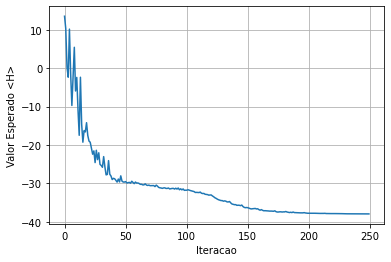

In [195]:
plt.plot(conv)
plt.xlabel("Iteracao")
plt.ylabel("Valor Esperado <H>")
plt.grid()